In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 477189131


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 200
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    #'to_freeze_count': 155,
    "to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)
print("Model loaded")

Model loaded


# Test before training on a pretrained model!

In [22]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer)
def test_regular_sampler():
    print(model_manager.say_raw("The dragon flew", 50, 0.7))
test_regular_sampler()

The dragon flew towards me, throwing himself on the box."<d><scn>np2y<msg>m "The dragon moved and bounced a lot. I looked at the effects in front of me. I saw some bright lights in their unforgetrous form, bright then not so bright now."<|endoftext|>


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

Dataset demo snapshot:
<d><scn>pad<msg>Br "Daaamn, my head. Why are you even here?"<|endoftext|><p><msg>c "Hello. I have a few questions about the murder of your colleague."<d><scn>o2<msg>An "Is that so? Why do you get to go around asking questions like that? Is it a matter of human interest?"<|endoftext|><p><msg>c "I guess I should go."<d><scn>np2x<msg>Ad "Goodbye, [player_name]."<p><msg>c "Good
bye, Adine. Take care of yourself."<|endoftext|><p><msg>c "I don't know. Don't you think my visit will overshadow your efforts? People may not be so interested in playing a game about humans anymore if they had a real one show up."<d><scn>black<msg>Lo "Good point, but the vast majority won't get to meet you personally, anyway. If I say I did and modeled the humans in the game after you, people will flock to it to get a similar experience."<p><msg>c "Does that mean I'm going to be your game
[0] set freeze_part_layers: True (freezing 11 out of 12 gpt blocks.)


Step,Training Loss
104,2.425300
208,1.790700
312,1.523300
416,1.304200
520,1.123100
624,0.969900
728,0.858200
832,0.748900
936,0.668700
1040,0.597400


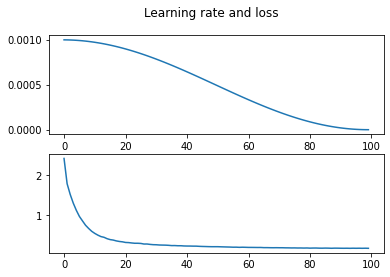

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [9]:
model.eval()
test_regular_sampler()

The dragon flew towards me, launching a big, angry grin on it."<d><scn>black<msg>n "According to his wishes, I left, wondering what went wrong between us."<d><scn>black<msg>n "I just wanted to help, and that was how he showed his gratitude?"<d><scn>black<msg>n "I could certainly live without Bryce from now on, then."<|endoftext|>


In [23]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: park2<msg>Ry "You are a real lifesaver, [player_name]."<d><msg>m "The dragon moved and let out a groan before he opened his eyes."<d><scn>park2<msg>Ry "Just as you do, occasionally, he pounced on me."<d><msg>eez<msg>Ry "Just because you thought you wanted to ask me a few questions, he


Prompt: What do you think of Lorem?
Reply: bare<msg>Lo "It's good to see you! I thought you might not show up."<p><msg>c "It's good to see you! I thought you might not show up."<d><scn>bare<msg>Lo "It's good to see you! I thought you might not show up."<p><msg>c "It's going to be a


Prompt: Oh my god, Adine. What is this?
Reply: park4<msg>Br "It's nothing, it's a waste of time."<d><scn>park4<msg>Br "To be honest, no one else has a similar opinion, so I just have to make the most of this."<d><scn>park4<msg>Em "You're a real lifesaver, [player_name]."<d><scn>


Prompt: What will we do here?
Reply: facin2<msg>Br "I'll just take a few notes."<|endoftext|>




# Sampling test

This is gonna be interesting!

In [24]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "How are you?"<p><msg>c "You are a really strong person. What can I bring you?"<d><scn>park2<msg>Ry "Just... don't..."<d><scn>park2<msg>Ry "Thank you!"<d><scn>park2<msg>Ry "Alright, I'll give you something to fill your belly with soon."

[Test 1] -> Prompt: What do you think of Lorem?
Reply: bare<msg>Lo "It's good to see you! I thought you might not show up."<p><msg>c "It's good to see you! I thought you might not show up."<d><scn>bare<msg>Lo "It's good to see you! I thought you might not show up."<p><msg>c "It's really good to see

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: park3<msg>Br "Just having a meal is enough. Aren't you supposed to be working as a courier, anyway?"<d><scn>park3<msg>Br "We're already here, really. Actually, anyway. Besides, I don't really want to fly back in the rain."<d><scn>station3<msg>Br "That's what I think."<|endoftext|>

[Test 1] -> Prompt: What will we do here?
Reply: facin2<msg>Br "I'

In [12]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined